<font color="red"> In conclusion, HPF doesn't seem to improve the stability of RDM

In [1]:
import itertools
import matlab.engine
import plotly.express as px
import plotly.graph_objs as go
import plotly

import drs
import numpy as np
import seaborn as sns

import pingouin

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import time
import pandas as pd
import glob
from copy import deepcopy
import os
import sys
from joblib import Parallel, delayed, cpu_count, dump,load
import plotly.express as px

from zpyhelper.filesys import checkdir
from zpyhelper.MVPA.rdm import compute_rdm,lower_tri,upper_tri, compute_rdm_nomial, compute_rdm_identity
from zpyhelper.MVPA.preprocessors import scale_feature, average_odd_even_session,normalise_multivariate_noise, split_data, concat_data,extract_pc,average_flexi_session
from zpyhelper.MVPA.estimators import PatternCorrelation, MultipleRDMRegression, NeuralRDMStability

project_path = r'E:\pirate_fmri\Analysis'
sys.path.append(project_path)
from scripts.Exp1_fmri.multivariate.modelrdms import ModelRDM
from scripts.Exp1_fmri.multivariate.mvpa_runner import MVPARunner
from scripts.Exp1_fmri.multivariate.pirateOMutils import parallel_axes_cosine_sim, minmax_scale, generate_filters
from src.utils.composition_modelfit import multi_start_optimisation

import sklearn
from sklearn.manifold import MDS,TSNE 
import sklearn.manifold as manifold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor,MultiOutputClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score,r2_score

import scipy

import plotly.graph_objects as go
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

In [3]:
study_scripts   = os.path.join(project_path,'scripts','Exp1_fmri')
studydata_dir  = os.path.join(project_path,'data','Exp1_fmri')
with open(os.path.join(study_scripts,'pirate_defaults.json')) as f:
    pirate_defaults = json.load(f)
    subid_list = pirate_defaults['participants']['validids']
    cohort1ids = [x for x in pirate_defaults['participants']['cohort1ids'] if x in subid_list]
    cohort2ids = [x for x in pirate_defaults['participants']['cohort2ids'] if x in subid_list]
    fmribeh_dir = pirate_defaults['directory']['fmribehavior']
    fmridata_dir = pirate_defaults['directory']['fmri_data']
    nongeneralizers = pirate_defaults['participants']["nongeneralizerids"]
    generalizers    = pirate_defaults['participants']["generalizerids"]
print(len(subid_list))
print(len(cohort1ids))
print(len(cohort2ids))

fmridata_dir = os.path.join(project_path,'data','Exp1_fmri','fmri')
fmribeh_dir = os.path.join(fmridata_dir,'beh')

cohort_names_lists = dict(zip(["First Cohort","Second Cohort","Combined Cohort"],[cohort1ids,cohort2ids,subid_list]))
    

56
29
27


In [4]:
base_rois = ["HPC","vmPFC","IPS","V1","V2"]
rois =  [f"{x}_bilateral" for x in base_rois]

ROIRSAdirs = {"hpf128": os.path.join(fmridata_dir,'ROIRSA','hpf180','AALandHCPMMP1bilateral'),
              "hpf180": os.path.join(fmridata_dir,'ROIRSA','AALandHCPMMP1bilateral')}
roi_datas = dict(zip(ROIRSAdirs.keys(),
                     [load(os.path.join(d,"roi_data_4r.pkl")) for d in ROIRSAdirs.values()]))


## Compare ROI RDM stability and similarity

In [26]:
navirdm = {}
lzerrdm = {}
navistablity = {}
for hpf in roi_datas.keys():
    navirdm[hpf],lzerrdm[hpf],navistablity[hpf] = {},{},{}
    for roi in rois:
        navirdm[hpf][roi] = {"Generalizer":[],"nonGeneralizer":[]}
        lzerrdm[hpf][roi] = {"Generalizer":[],"nonGeneralizer":[]}
        navistablity[hpf][roi] = {"Generalizer":[],"nonGeneralizer":[]}
        for subid,subdata in zip(subid_list,roi_datas[hpf][roi]):
            subgroup = "Generalizer" if subid in generalizers else "nonGeneralizer"

            navi_filter = subdata["stimdf"].taskname.to_numpy() == "navigation"
            lzer_filter = subdata["stimdf"].taskname.to_numpy() == "localizer"

            naviX = subdata["preprocX"][navi_filter]
            navi_sess = subdata["stimdf"].stim_session[navi_filter].to_numpy()
            navi_aall = np.mean(split_data(naviX,navi_sess),axis=0)
            navirdm[hpf][roi][subgroup].append(compute_rdm(navi_aall,metric="correlation"))

            navi_aoe = average_odd_even_session(naviX,navi_sess)
            naviX_odd,naviX_even = navi_aoe[:25],navi_aoe[25:]
            navirdm_odd, navirdm_even = compute_rdm(naviX_odd,metric="correlation"), compute_rdm(naviX_even,metric="correlation")
            odd_even_corr = scipy.stats.pearsonr(upper_tri(navirdm_odd)[0],upper_tri(navirdm_even)[0]).statistic
            navistablity[hpf][roi][subgroup].append(odd_even_corr)

            lzerX = subdata["preprocX"][navi_filter]
            lzerrdm[hpf][roi][subgroup].append(compute_rdm(lzerX,metric="correlation"))


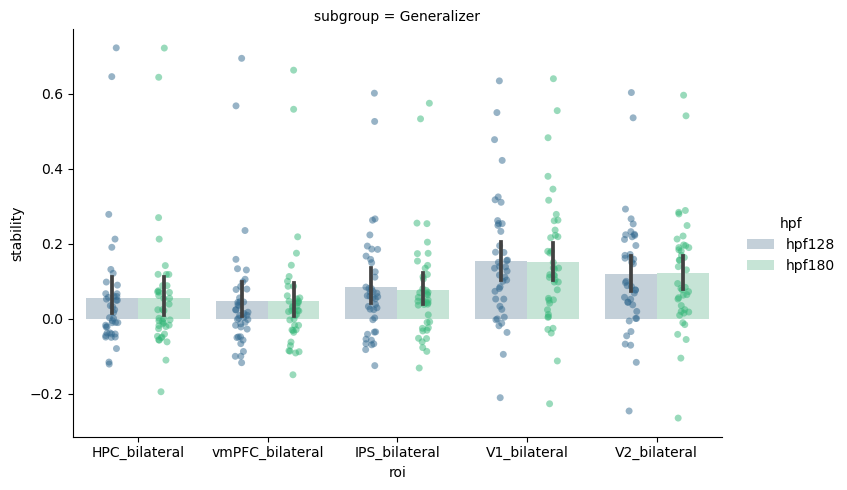

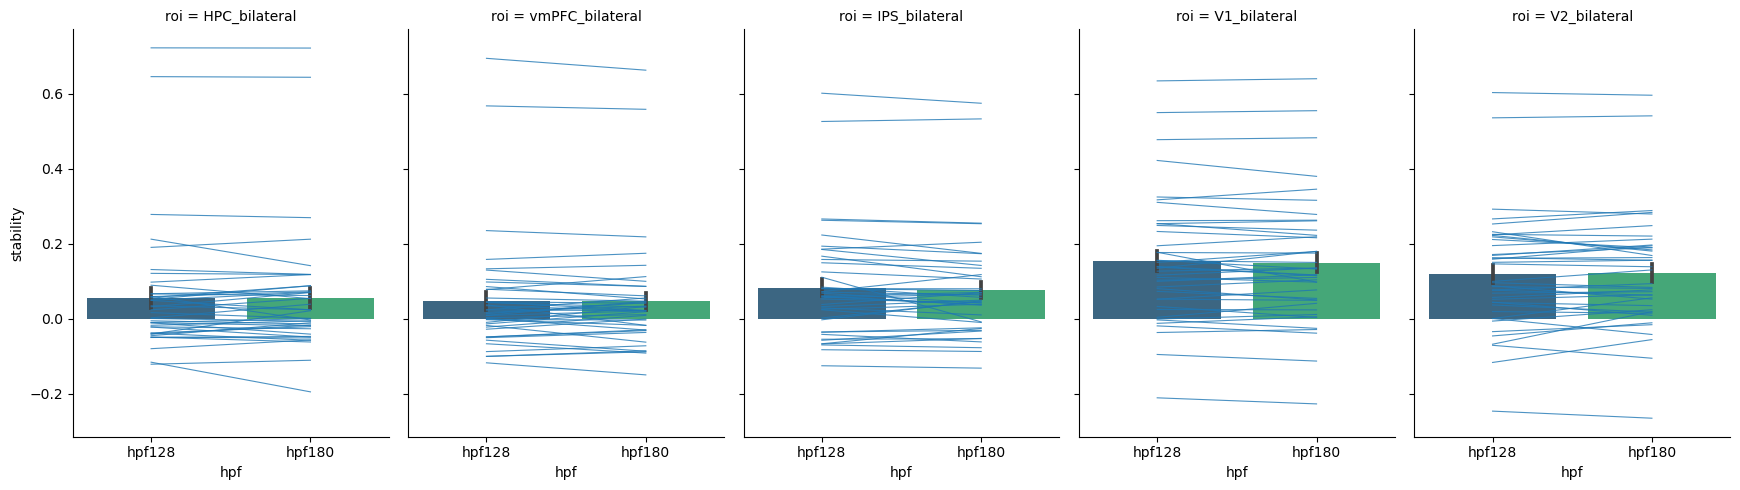

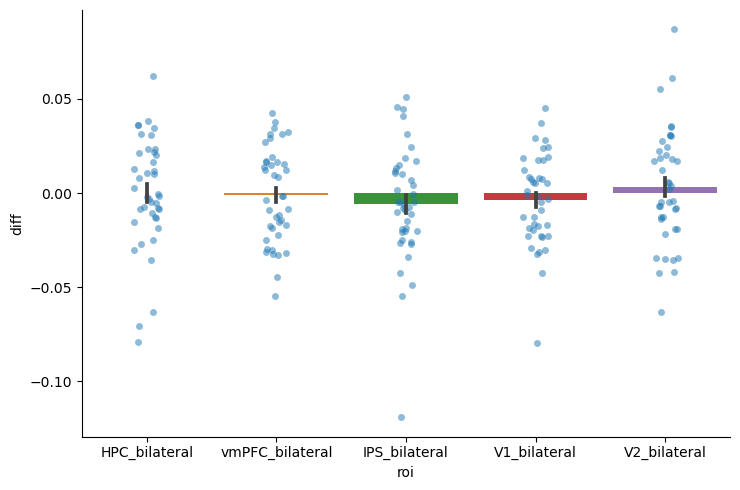

In [64]:
GSID = [x for x in subid_list if x in generalizers]
G_stability_df = pd.concat([pd.DataFrame({"stability":navistablity[hpf][roi]["Generalizer"]}).assign(hpf=hpf,roi=roi,subgroup="Generalizer",subid=GSID) for roi in rois for hpf in roi_datas.keys()]).reset_index(drop=True)  
gs = sns.catplot(data=G_stability_df,x="roi",y="stability",
                 hue="hpf",palette=sns.color_palette("viridis",n_colors=2),
                 kind="bar",col="subgroup",alpha=0.3,
                 sharey=False,aspect=1.5)
gs.map_dataframe(sns.stripplot, x="roi", y="stability", 
                 hue="hpf", palette=sns.color_palette("viridis",n_colors=2),
                 dodge=True, 
                 alpha=0.5, zorder=1)

gs2 = sns.catplot(data=G_stability_df,x="hpf",y="stability",
                 hue="hpf",palette=sns.color_palette("viridis",n_colors=2),
                 kind="bar",col="roi",aspect=0.7,dodge=False,
                 errorbar="se")
gs2.map_dataframe(sns.lineplot, x="hpf", y="stability",units="subid",estimator=None,
                  alpha=0.8,linewidth=0.8)

G_stability_df_wide = pd.concat(
    [pd.DataFrame({"hpf128":navistablity["hpf128"][roi]["Generalizer"],
                   "hpf180":navistablity["hpf180"][roi]["Generalizer"]}).assign(roi=roi,subgroup="Generalizer",subid=GSID) for roi in rois]
).reset_index(drop=True)
G_stability_df_wide["diff"] = G_stability_df_wide["hpf180"] - G_stability_df_wide["hpf128"]
gs3 = sns.catplot(data=G_stability_df_wide, 
            x="roi", y="diff",kind="bar",
            errorbar="se",
            aspect=1.5)
gs3.map_dataframe(sns.stripplot, x="roi", y="diff",
                  alpha=0.5, zorder=1)
#gs3.map_dataframe(sns.lineplot, x="roi", y="diff",units="subid",estimator=None)

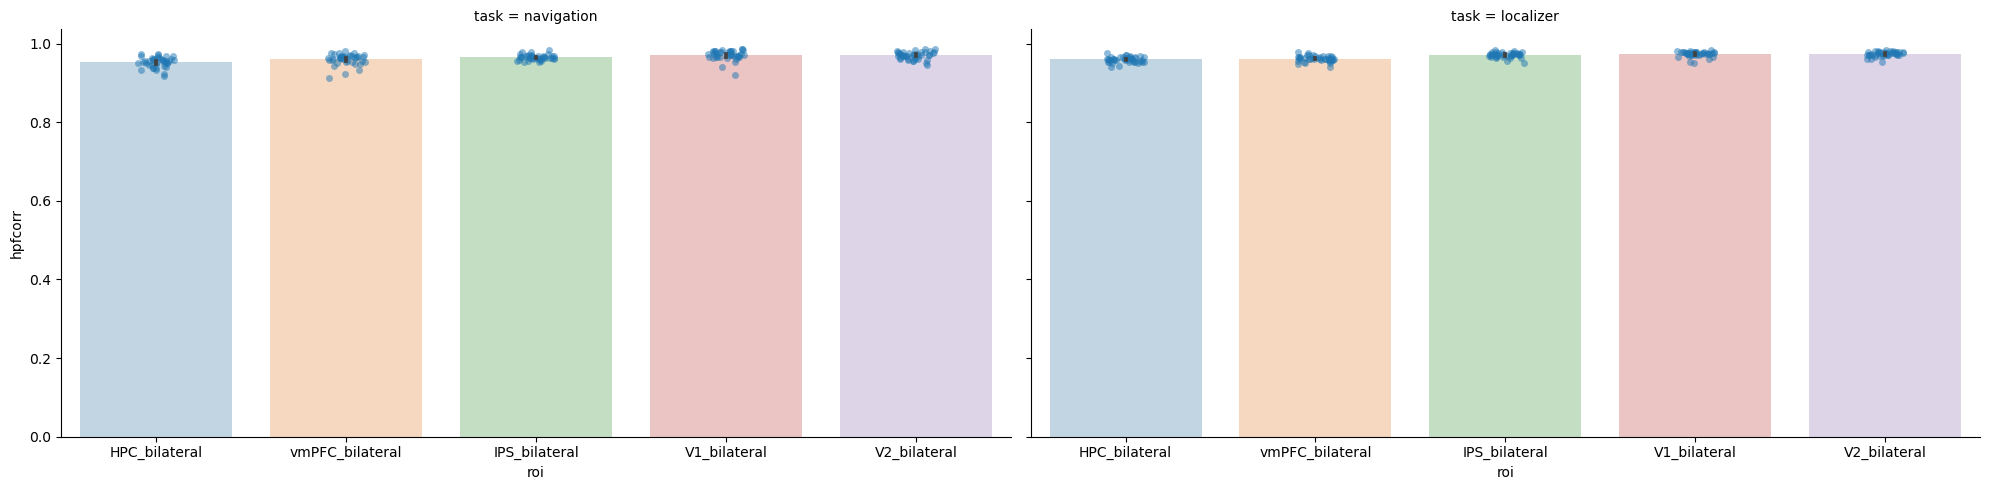

In [71]:

hpfcorr_dfs = [pd.DataFrame({
    "hpfcorr":
    [scipy.stats.spearmanr(lower_tri(x1)[0], lower_tri(x2)[0]).statistic for x1,x2 in zip(navirdm["hpf128"][roi]["Generalizer"],navirdm["hpf180"][roi]["Generalizer"])]
    }).assign(roi=roi,subid=GSID, task="navigation") for roi in rois] + \
    [pd.DataFrame({
    "hpfcorr":
    [scipy.stats.spearmanr(lower_tri(x1)[0], lower_tri(x2)[0]).statistic for x1,x2 in zip(lzerrdm["hpf128"][roi]["Generalizer"],lzerrdm["hpf180"][roi]["Generalizer"])]
    }).assign(roi=roi,subid=GSID, task="localizer") for roi in rois]
hpfcorr_df = pd.concat(hpfcorr_dfs,axis=0).reset_index(drop=True)
gs = sns.catplot(hpfcorr_df,
            x="roi",y="hpfcorr",
            col="task",kind="bar",
            alpha=0.3,aspect=2)
gs.map_dataframe(sns.stripplot, x="roi", y="hpfcorr",
                 dodge=True, alpha=0.5, zorder=1)